In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from haversine import haversine
CSV_DATA = Path().cwd().parent.parent / "data/0_extracted/processed/"

In [2]:
def read_ride_csv(file_path:str, time_columns:list[str]=None):
    if time_columns is None: time_columns=['time']
    # Read in the CSV file for the Ride
    df = pd.read_csv(file_path)
    
    # guarantee the timestamps are datetime objects
    for time_col in time_columns:
        df[time_col] = pd.to_datetime(df[time_col])

    return df

In [3]:
jan_ride_path = CSV_DATA / "January_no_sensor.csv"
apr_ride_path = CSV_DATA / "April_one_sensor.csv"
may_ride_path = CSV_DATA / "May_two_sensor.csv"
df_jan = read_ride_csv(jan_ride_path)
df_apr = read_ride_csv(apr_ride_path)
df_may = read_ride_csv(may_ride_path)

In [4]:
drop_columns = ['ride_id', 'track_id']
df_jan = df_jan.drop(columns=drop_columns)
df_apr = df_apr.drop(columns=drop_columns)
df_may = df_may.drop(columns=drop_columns)
add_null_columns = ['atemp', 'hr'] # if these columns don't already exist add them as np.null

for df in [df_jan, df_apr, df_may]:
    for col in add_null_columns:
        if col not in df.columns:
            df[col] = np.nan

In [5]:
def plot_state_column(df:pd.DataFrame, column:str, color_by:str='segment_id',figsize=(15,3),
                       ylims:list[float]=None, units:str='none') -> None:
    _ = plt.figure(figsize=figsize)
    _ = sn.lineplot(df, x='elapsed_time', y=column, hue=color_by, palette='hls', legend=False)
    _ = plt.grid()
    _ = plt.title(f'{column.upper()} Segments', fontsize=18)
    _ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
    _ = plt.ylabel(f'{column.upper()} ({units})', fontsize=14)
    if ylims is not None:
        _ = plt.ylim(ylims)

# 1. Enrich & Upsample Time

In [6]:
class TimeUpsampler:
    def process(self, df:pd.DataFrame, time_gap_threshold:int=15) -> pd.DataFrame:
        df = df.copy()
        df = self.enrich_time_data(df)
        df['elapsed_time'] = df['delta_time'].cumsum()
        df = self.label_continuous_segments(df, time_gap_threshold)
        return df

    def upsample(self, df:pd.DataFrame) -> pd.DataFrame:
        df_upsampled = self.normalize_sampling_rate(df)
        return df_upsampled

    @staticmethod
    def enrich_time_data(df:pd.DataFrame, time_column:str='time', fill_first:float=1.0):
        df = df.copy()
        # Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
        df['time_utc'] = df[time_column].apply(lambda x: x.timestamp())
        
        # Calculate the row-wise difference in time (in seconds)
        df['delta_time'] = df['time_utc'].diff()
        
        # drop the temporary time column
        df.drop(['time_utc'], axis=1, inplace=True)
        
        # fill in the initial value of delta_time with @fill_first
        df['delta_time'] = df['delta_time'].fillna(fill_first)
        
        return df
    
    @staticmethod
    def label_continuous_segments(df: pd.DataFrame, time_gap_threshold:int=15):
        df = df.copy()
        # get the time gap indices
        # Calculate when the time discontinuities occur
        filt_time_jump = df['delta_time'] >= time_gap_threshold
        time_gap_indices = list(df.loc[filt_time_jump, 'time'].index)

        # intialize the initial segment_id. to be incremented for each region of continuous data
        segment_id_counter = 0
        # initialize the starting index of the first segment
        segment_start_index = 0

        for time_gap_index in time_gap_indices:
            # Assign the Segment ID
            df.loc[segment_start_index:time_gap_index-1, 'segment_id'] = segment_id_counter
            
            # update the segment_id counter and start index
            segment_id_counter += 1
            segment_start_index = time_gap_index
            
        # Since segment_id == -1 by default, this represents the final segment of activity once parsed
        df['segment_id'] = df['segment_id'].replace({-1:segment_id_counter})

        return df
    
    @staticmethod
    def upsample_and_interpolate(df: pd.DataFrame, time_column:str='time', method:str='spline', limit_direction:str='forward'):
        # Since the delta_time column is no longer needed to detect discontinuities,
        # Drop delta_time so we can rebuild it at a segment_id level
        df.drop(['delta_time'], axis=1, inplace=True)
        
        # set the timestamp as the index for the dataframe
        kwargs = dict(method=method, limit_direction=limit_direction)
        if method=='spline':
            kwargs['order']=2
        df = df.set_index(time_column).copy()
        df = df.resample('s').interpolate(**kwargs).reset_index()
        return df
    
    def normalize_sampling_rate(self, df: pd.DataFrame, partition_column:str='segment_id') -> pd.DataFrame:
        df = df.copy()
        functions_to_apply = [self.upsample_and_interpolate, self.enrich_time_data]
        for func in functions_to_apply:
            df = pd.concat(list(map(func, [df_group for _,df_group in df.groupby(partition_column)])), ignore_index=True).sort_index()
        return df

In [7]:
upsampler = TimeUpsampler()
df_jan = upsampler.process(df_jan)
df_apr = upsampler.process(df_apr)
df_may = upsampler.process(df_may)

In [8]:
def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=0.0):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df_gps = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the distance between rows
    haversine_distance = lambda x: max(0,haversine((x.iloc[0], x.iloc[1]), (x.iloc[2], x.iloc[3]), unit='ft'))
    
    # Create the distance column, making sure to apply the function row-by-row
    df['delta_dist_ft'] = df_gps.apply(haversine_distance, axis=1)
    df['delta_dist_ft'] = df['delta_dist_ft'].fillna(fill_first)
    
    # Remove the old latitude and longitude columns
    df.drop(['lat_old','long_old'], axis=1, inplace=True)
    return df

def compute_grade(df):
    df = df.copy()
    fill_first = 0.0
    df['delta_ele_ft'] = df['elevation'].diff()
    df['delta_ele_ft'] = df['delta_ele_ft'].fillna(fill_first)
    df['grade'] = 100.0 * (df['delta_ele_ft'] / df['delta_dist_ft'])
    df.loc[0,'grade'] = 0.0 # initialize and assumed 0% slope as the starting point--representative of a typical parking lot
    df.loc[~np.isfinite(df['grade']),'grade'] = np.nan
    # fill in nulls where delta_dist==0.0 by interpolating the value. If you stop on a hill, your grade should carry forward
    df['grade'] = df['grade'].interpolate('spline', order=2)
    return df

In [9]:
df_apr = compute_distance(df_apr)
meters_to_feet = 3.281
df_apr['elevation'] = df_apr['elevation'] * meters_to_feet

In [10]:

df_apr = compute_grade(df_apr)


In [11]:
cols_of_interest = ['segment_id','elapsed_time','elevation','delta_ele_ft','delta_dist_ft','grade',]
df_apr.loc[160:200,:].head(20)

,segment_id,time,elevation,latitude,longitude,atemp,hr,delta_time,elapsed_time,delta_dist_ft,delta_ele_ft,grade
160,0,2025-04-12 17:29:50+00:00,524.3038,39.153793,-84.320465,24,136,7.0,518.0,81.816811,0.6562,0.802036
161,0,2025-04-12 17:29:51+00:00,524.9600,39.153814,-84.320443,24,136,1.0,519.0,9.870495,0.6562,6.648096
162,0,2025-04-12 17:29:56+00:00,526.2724,39.153888,-84.320336,24,135,5.0,524.0,40.559298,1.3124,3.235756
163,0,2025-04-12 17:29:59+00:00,526.2724,39.153888,-84.320333,24,133,3.0,527.0,0.848686,0.0000,0.000000
164,0,2025-04-12 17:30:01+00:00,526.2724,39.153888,-84.320333,24,131,2.0,529.0,0.000000,0.0000,134.900915
165,0,2025-04-12 17:30:04+00:00,526.2724,39.153888,-84.320333,24,128,3.0,532.0,0.000000,0.0000,215.197670
166,0,2025-04-12 17:30:10+00:00,525.6162,39.153888,-84.320333,24,128,6.0,538.0,0.000000,-0.6562,241.766507
167,0,2025-04-12 17:30:14+00:00,523.6476,39.153888,-84.320333,24,131,4.0,542.0,0.000000,-1.9686,214.607426
168,0,2025-04-12 17:30:21+00:00,524.3038,39.153888,-84.320333,24,134,7.0,549.0,0.000000,0.6562,133.720428
169,0,2025-04-12 17:30:22+00:00,524.3038,39.153886,-84.320331,24,134,1.0,550.0,0.923295,0.0000,0.000000


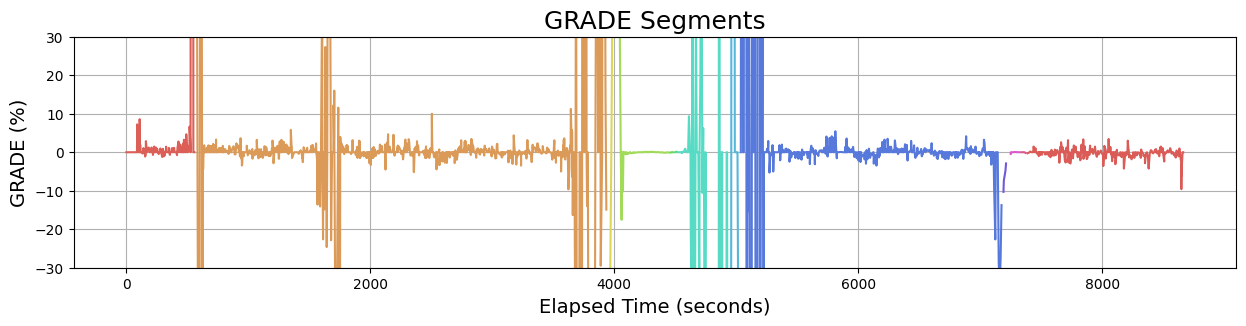

In [12]:
plot_state_column(df_apr,'grade', units='%', ylims=[-30, 30])

# Basic Enrichments

In [ ]:
from functools import reduce

class BasicEnricher:
    def process(self, df:pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        process_steps = [self.compute_distance, self.compute_heading, self.compute_speed, self.flag_cruising_rows, 
                         self.convert_elevation, self.compute_grade, self.compute_cumulative_elevation_changes]
        
        df_enriched = reduce(lambda df,func:func(df), process_steps, df)
        return df_enriched

    ##############################################################################################
    # Distance and Heading from Lat/Long
    ##############################################################################################
    @staticmethod
    def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=0.0):
        df = df.copy()
        # Copy the previous values of Lat/Long to the current row for vectorized computation
        df['lat_old'] = df[latitude].shift()
        df['long_old'] = df[longitude].shift()
        
        # Grab the relevant columns for distance calculation
        df_gps = df[['lat_old', 'long_old', latitude, longitude]]
        
        # Define an anonymous function to execute over each row to calculate the distance between rows
        # Units should be in feet to prevent floating point precision issues for other calculations. (lower noise)
        haversine_distance = lambda x: max(0,haversine((x.iloc[0], x.iloc[1]), (x.iloc[2], x.iloc[3]), unit='ft'))
        
        # Create the distance column, making sure to apply the function row-by-row
        df['delta_dist_ft'] = df_gps.apply(haversine_distance, axis=1)
        df['delta_dist_ft'] = df['delta_dist_ft'].fillna(fill_first)
        
        # Remove the old latitude and longitude columns
        df.drop(['lat_old','long_old'], axis=1, inplace=True)
        return df
    
    @staticmethod
    def compute_heading(df, latitude='latitude', longitude='longitude'):
        df = df.copy()
        # Copy the previous values of Lat/Long to the current row for vectorized computation
        df['lat_old'] = df[latitude].shift()
        df['long_old'] = df[longitude].shift()
        
        # Grab the relevant columns for distance calculation
        df_gps = df[['lat_old', 'long_old', latitude, longitude]]
        
        # Define an anonymous function to execute over each row to calculate the angle with North as 0 degrees
        # NOTE: we use "delta_lat / delta_long" to ensure that North = 0 degrees
        rad2deg = 180.0 / np.pi
        heading = lambda x: rad2deg * np.arctan2((x.iloc[2]-x.iloc[0]), (x.iloc[3]-x.iloc[1])) # atan(delta_lat / delta_long)
        
        # Create the distance column, making sure to apply the function row-by-row
        df['heading'] = df_gps.apply(heading, axis=1)
        df['heading'] = df['heading'].apply(lambda x: x + 360.0*(1-np.sign(x))/2) # correct for negative angles
        
        # Remove the old latitude and longitude columns
        df.drop(['lat_old','long_old'], axis=1, inplace=True)
        return df

    ##############################################################################################
    # Speed Enrichments
    ##############################################################################################
    @staticmethod
    def compute_speed(df):
        df = df.copy()
        feet_to_miles = 1.0 / 5280.0
        miles_per_second_2_MPH = 3600.0 / 1.0 # conversion factor
        df['speed'] = miles_per_second_2_MPH * (feet_to_miles*df['delta_dist_ft']) / df['delta_time']
        return df

    @staticmethod
    def flag_cruising_rows(df, start_threshold_mph:float=8.0, stop_threshold_mph:float=5.0):
        """
        Scmitt Trigger to implement a hysteresis state machine for determining a state
        """
        df = df.copy()
        df['is_cruising'] = False

        for k in range(1, df.shape[0]):
            previous_state = df.loc[k-1,'is_cruising']
            current_speed = df.loc[k,'speed']
            if (previous_state==False) & (current_speed >= start_threshold_mph):
                df.loc[k,'is_cruising'] = True # rising threshold surpassed
            elif (previous_state==True) & (current_speed < stop_threshold_mph):
                df.loc[k,'is_cruising'] = False # rising threshold surpassed
            else:
                # if there is no change, propogate the previous state
                df.loc[k,'is_cruising'] = df.loc[k-1,'is_cruising']
        return df

    ##############################################################################################
    # Elevation Enrichments
    ##############################################################################################
    @staticmethod
    def convert_elevation(df):
        df = df.copy()
        meters_to_feet = 3.281
        df['elevation'] = df['elevation'] * meters_to_feet
        return df

    @staticmethod
    def compute_grade(df):
        df = df.copy()
        fill_first = 0.0
        df['delta_ele_ft'] = df['elevation'].diff()
        df['delta_ele_ft'] = df['delta_ele_ft'].fillna(fill_first)
        df['grade'] = 100.0 * (df['delta_ele_ft'] / df['delta_dist_ft'])
        df.loc[0,'grade'] = 0.0 # initialize and assumed 0% slope as the starting point--representative of a typical parking lot
        df.loc[~np.isfinite(df['grade']),'grade'] = np.nan
        # fill in nulls where delta_dist==0.0 by interpolating the value. If you stop on a hill, your grade should carry forward
        df['grade'] = df['grade'].interpolate('spline', order=2)
        return df

    @staticmethod
    def compute_cumulative_elevation_changes(df, fill_first=0.0):
        df = df.copy()
        
        # create an elevation difference
        df['delta_ele'] = df['elevation'].diff()
        df['delta_ele'] = df['delta_ele'].fillna(fill_first)
        
        # create delta ascent and delta descent columns
        df['delta_ascent'] = df.loc[df['delta_ele']>=0, 'delta_ele']
        df['delta_descent'] = df.loc[df['delta_ele']<=0, 'delta_ele']
        
        # create the cumulative versions
        df['elapsed_ascent'] = df['delta_ascent'].cumsum()
        df['elapsed_ascent'] = df['elapsed_ascent'].interpolate() # fill in any blanks
        df['elapsed_descent'] = df['delta_descent'].cumsum()
        df['elapsed_descent'] = np.abs(df['elapsed_descent'].interpolate()) # fill in any blanks
        
        # create the total elevation change column
        df['elapsed_elevation'] = df['elapsed_ascent'] + df['elapsed_descent']
            
        # drop the elevation differences
        df.drop(['delta_ele','delta_ascent','delta_descent'], axis=1, inplace=True)
        
        return df

In [14]:
enricher = BasicEnricher()
df_jan = enricher.process(df_jan)
df_apr = enricher.process(df_apr)
df_may = enricher.process(df_may)

In [15]:
df_apr.head()

,segment_id,time,elevation,latitude,longitude,atemp,hr,delta_time,elapsed_time,delta_dist_ft,delta_ele_ft,grade,heading,speed,is_cruising,elapsed_ascent,elapsed_descent,elapsed_elevation
0,0,2025-04-12 17:21:13+00:00,1586.755251,39.139397,-84.341631,29,93,1.0,1.0,0.0,0.0,0.000000e+00,NaN,0.0,False,0.0,0.0,0.0
1,0,2025-04-12 17:21:14+00:00,1586.755251,39.139397,-84.341631,29,91,1.0,2.0,0.0,0.0,-2.749242e-10,180.0,0.0,False,0.0,0.0,0.0
2,0,2025-04-12 17:21:15+00:00,1586.755251,39.139397,-84.341631,29,94,1.0,3.0,0.0,0.0,-4.607065e-10,180.0,0.0,False,0.0,0.0,0.0
3,0,2025-04-12 17:21:16+00:00,1586.755251,39.139397,-84.341631,29,90,1.0,4.0,0.0,0.0,-5.571260e-10,180.0,0.0,False,0.0,0.0,0.0
4,0,2025-04-12 17:21:20+00:00,1586.755251,39.139397,-84.341631,29,87,4.0,8.0,0.0,0.0,-5.641825e-10,180.0,0.0,False,0.0,0.0,0.0


# Begin Inspecting the Enrichments

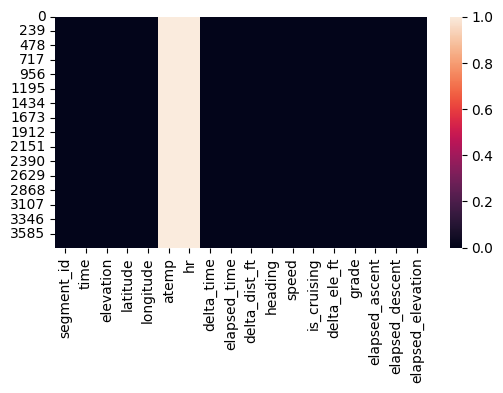

In [16]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_jan.isna())

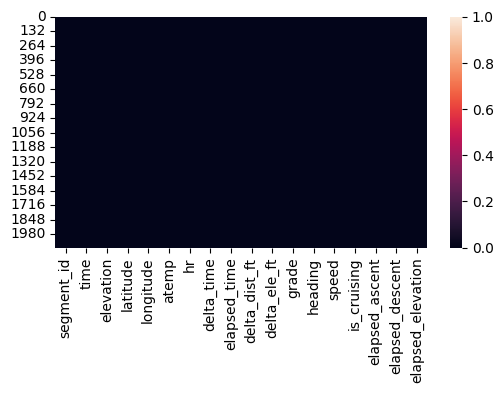

In [17]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_apr.isna())

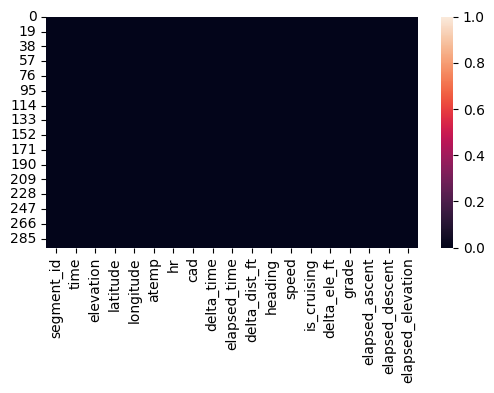

In [18]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_may.isna())

# Inspect the Enriched Columns

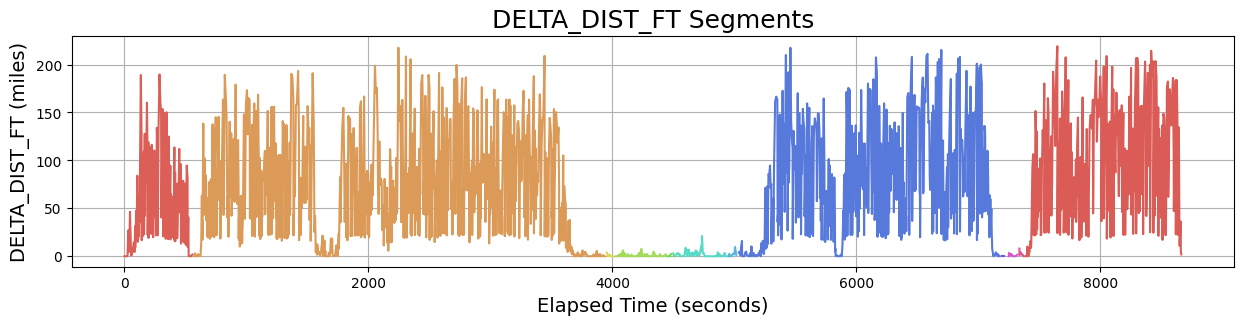

In [20]:
plot_state_column(df_apr,'delta_dist_ft', units='miles')

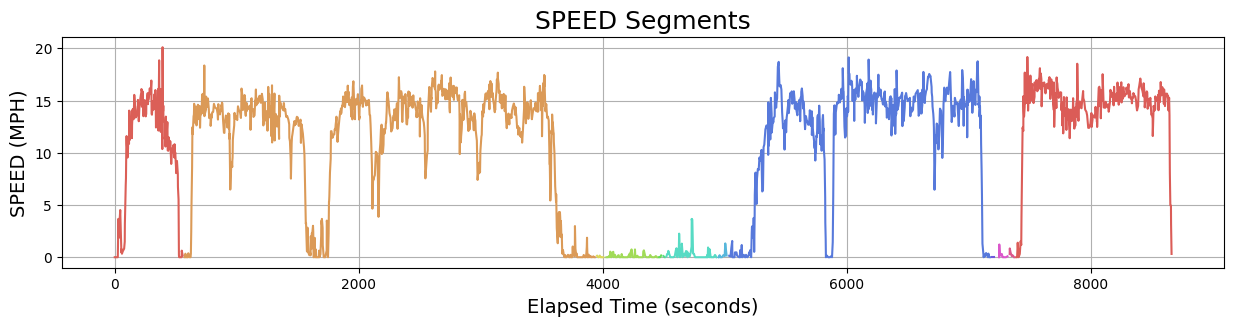

In [21]:
plot_state_column(df_apr,'speed', units='MPH')

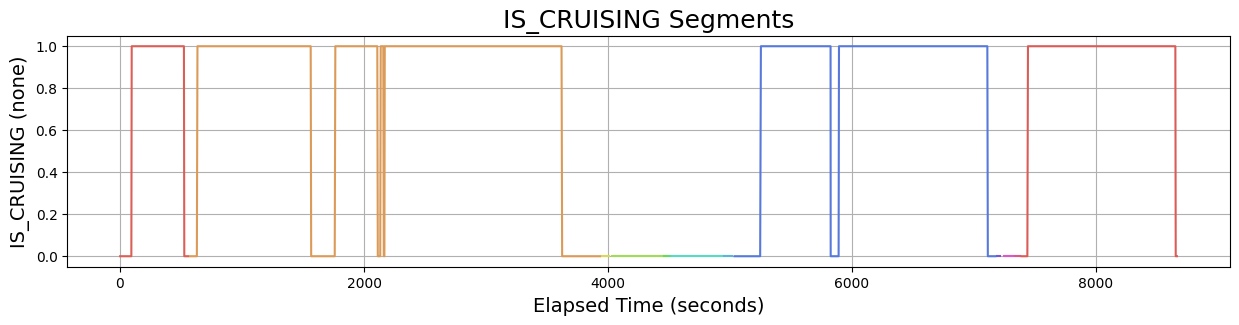

In [22]:
plot_state_column(df_apr,'is_cruising', units='none')

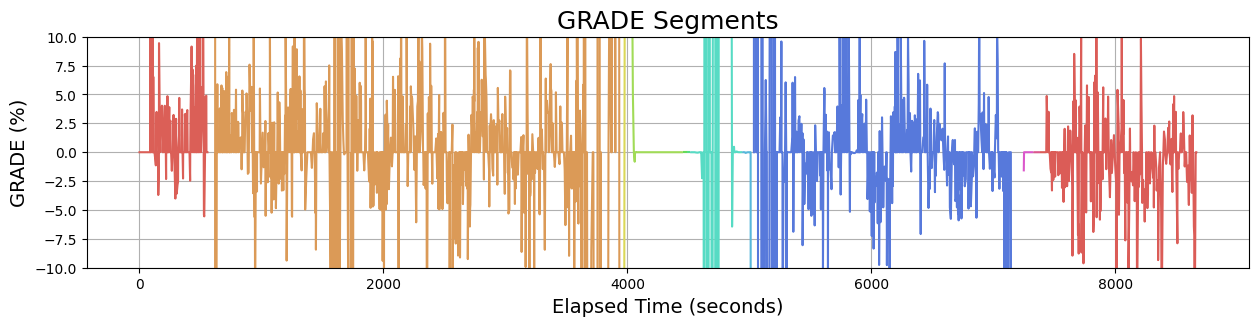

In [23]:
plot_state_column(df_apr,'grade', units='%', ylims=[-10,10])

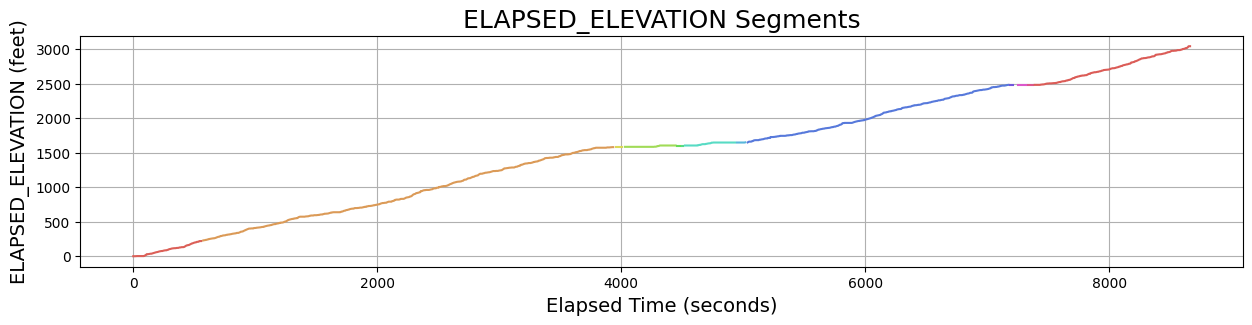

In [24]:
plot_state_column(df_apr,'elapsed_elevation', units='feet')

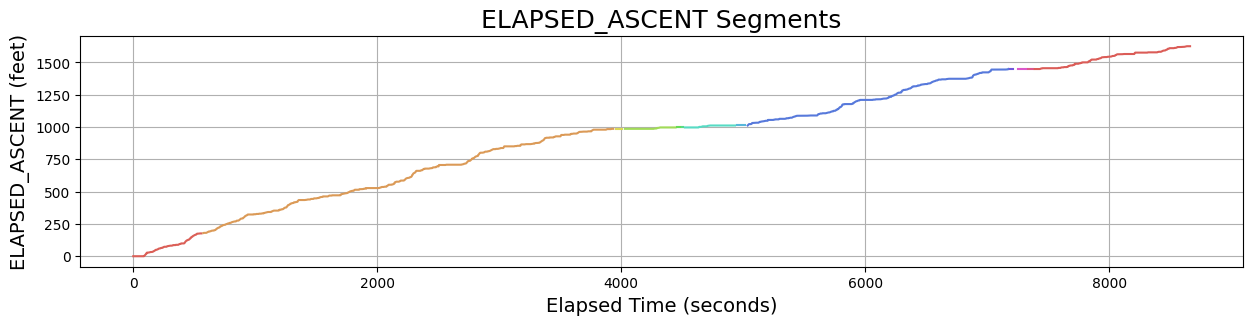

In [25]:
plot_state_column(df_apr,'elapsed_ascent', units='feet')

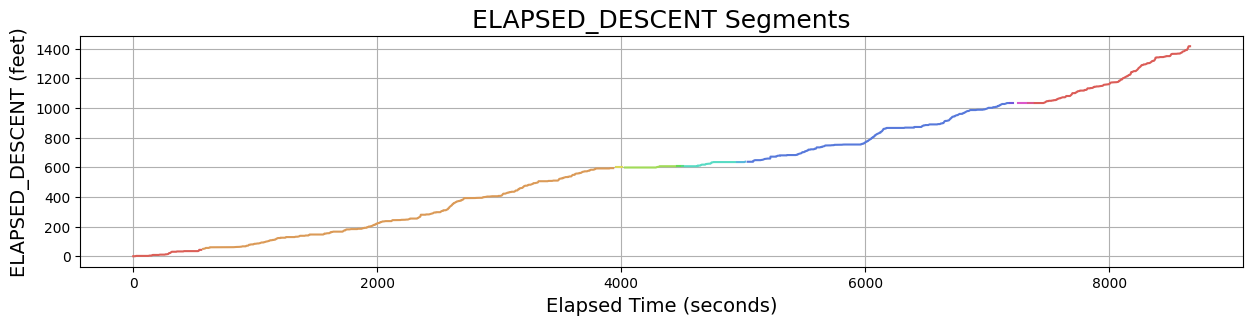

In [26]:
plot_state_column(df_apr,'elapsed_descent', units='feet')